1. DATA COLLECTION
--------------------------------------------------------------------------------
Data successfully loaded from source.

2. DATA EXPLORATION & CLEANING
--------------------------------------------------------------------------------
Date column converted to datetime.

3. TIME SERIES VISUALIZATION
--------------------------------------------------------------------------------


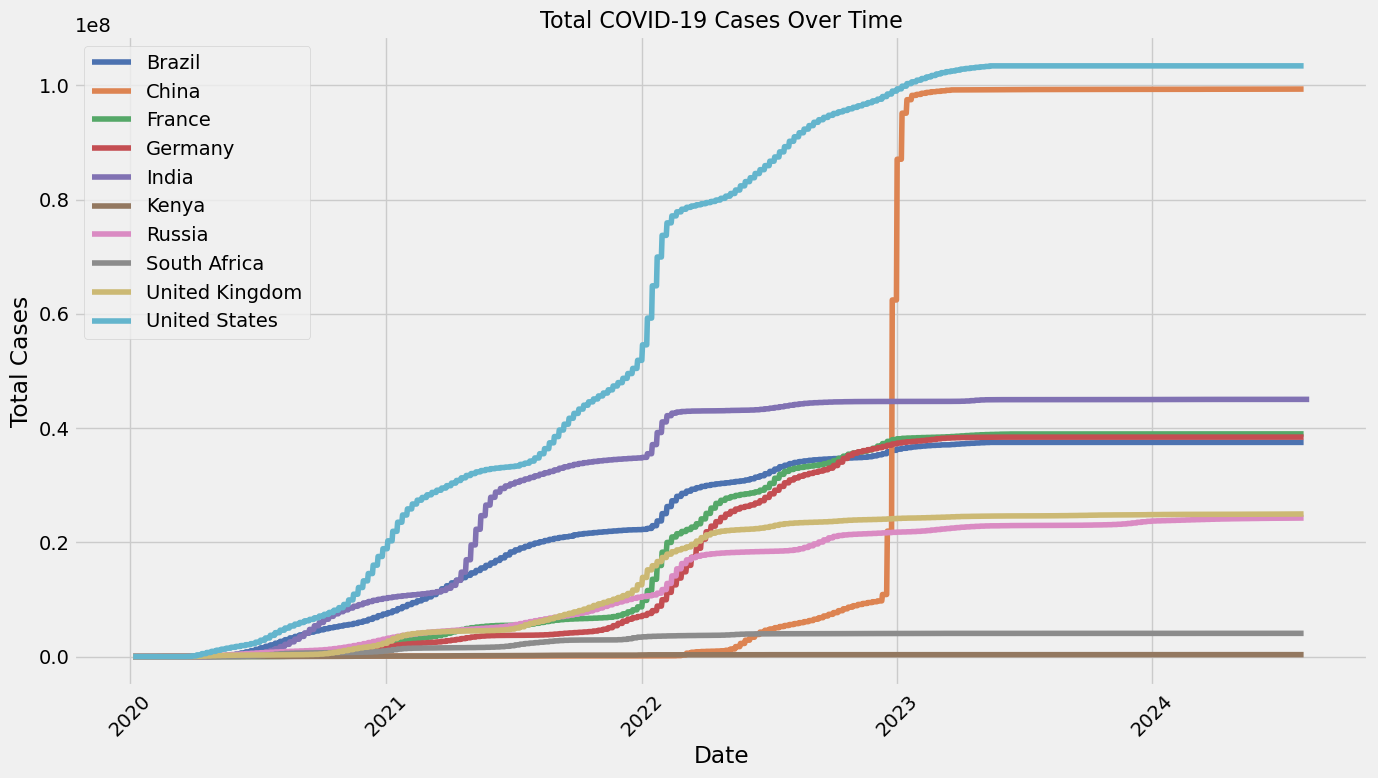

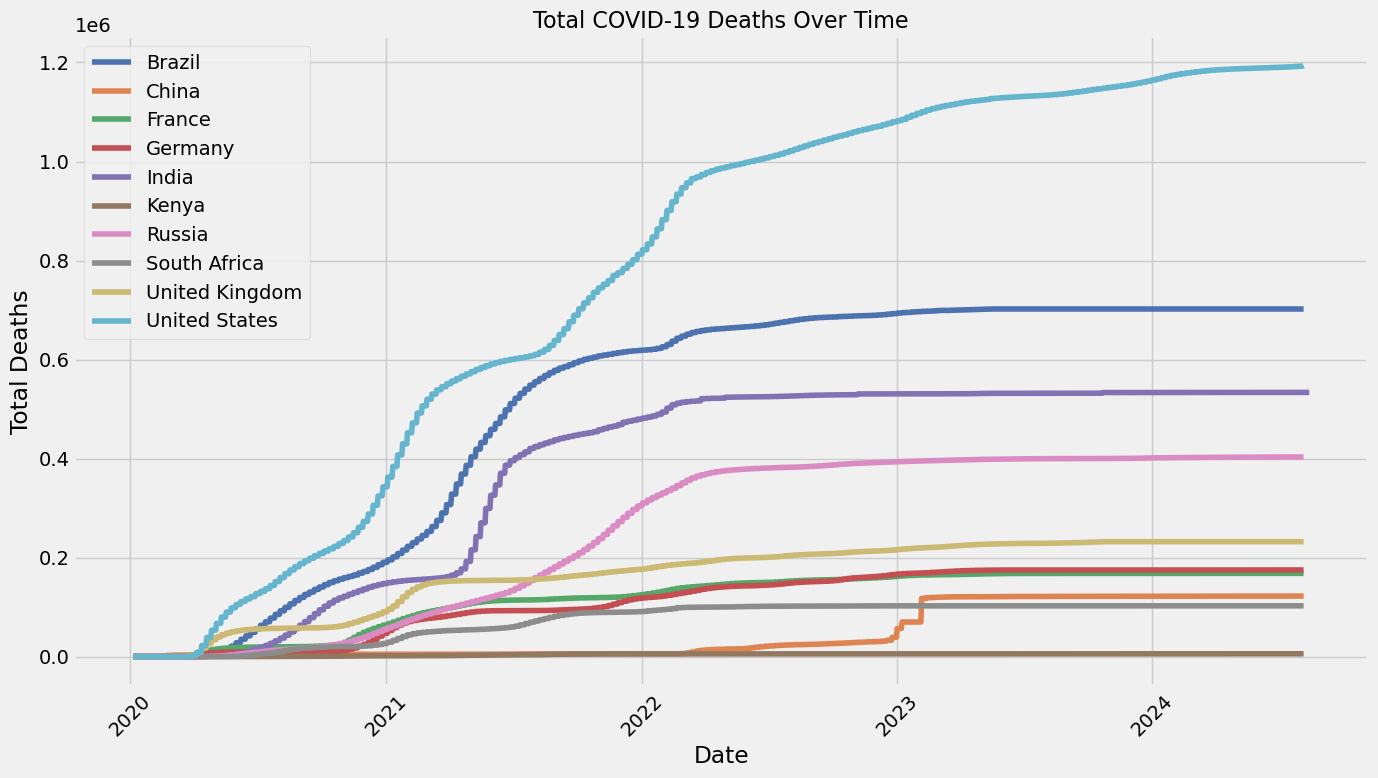

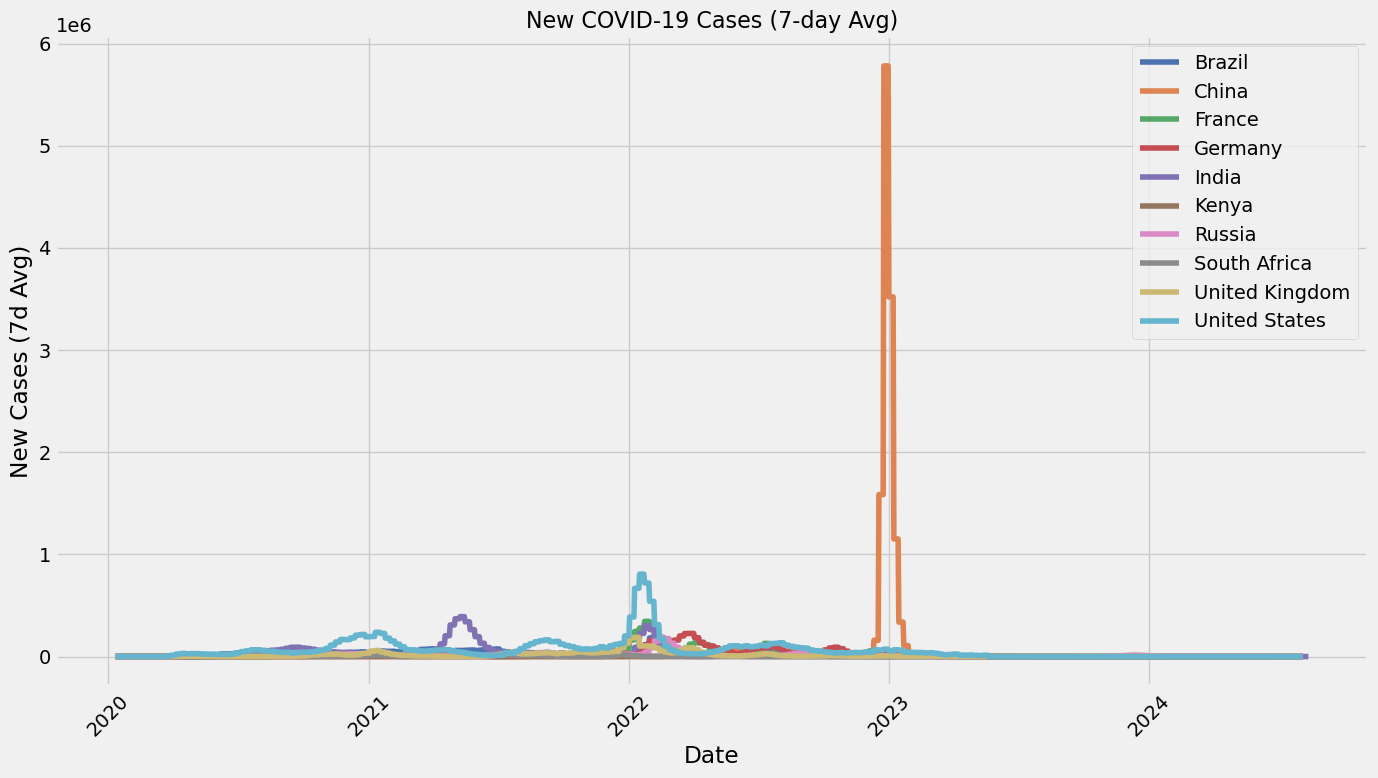

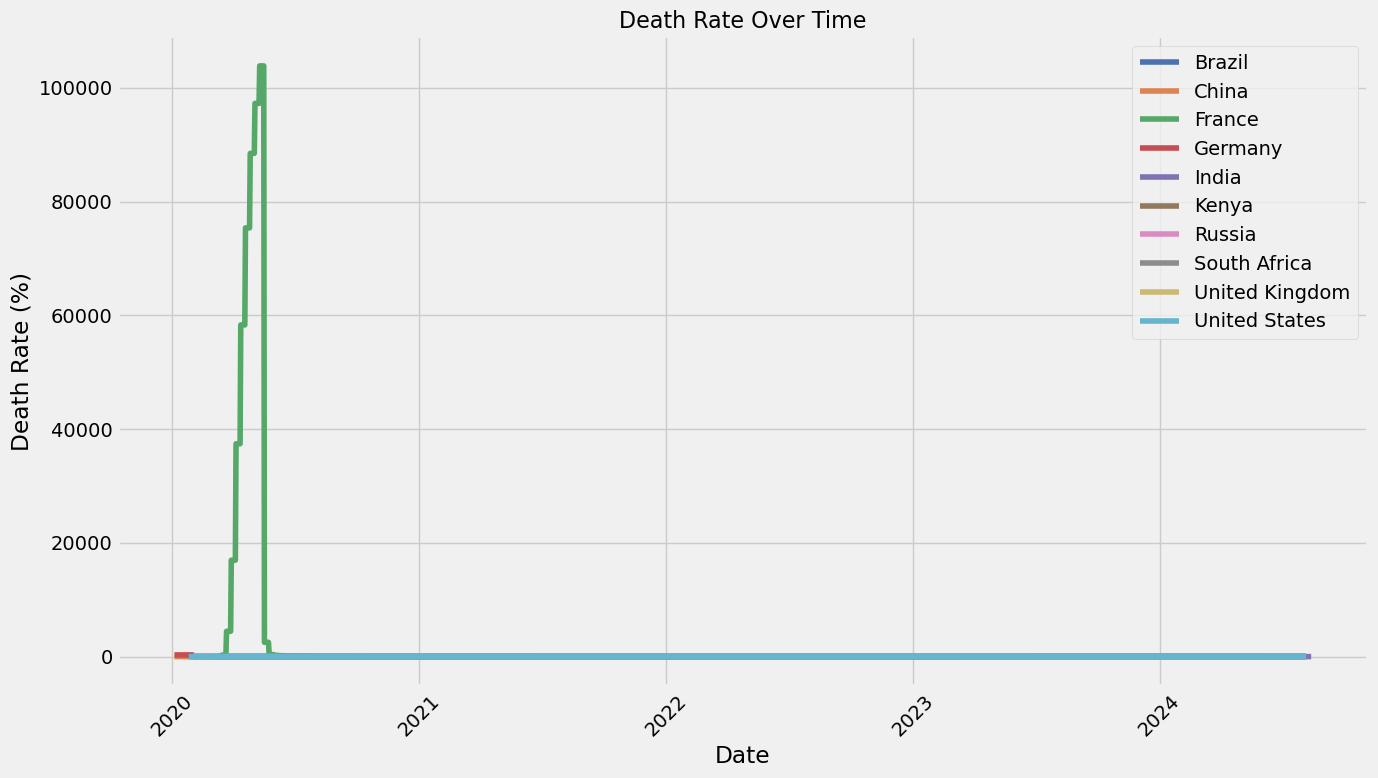

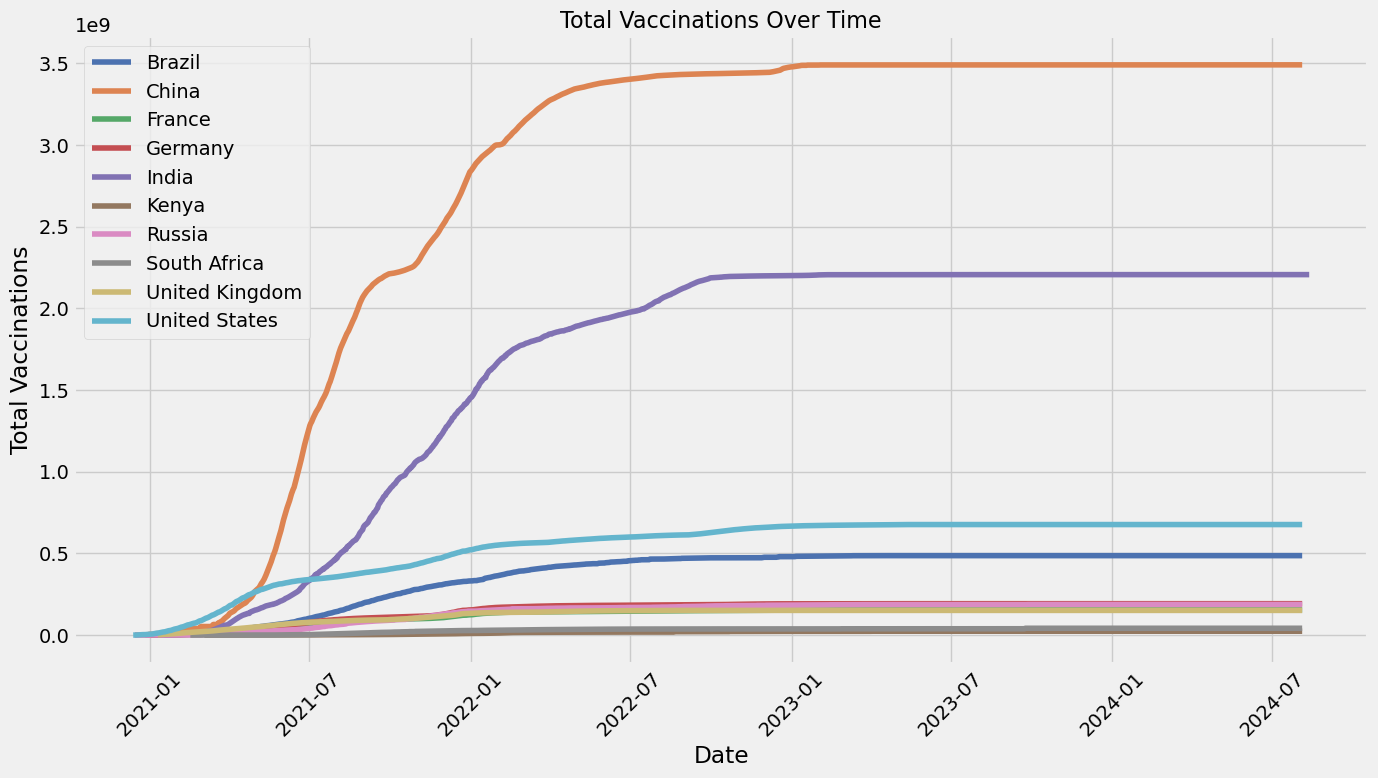

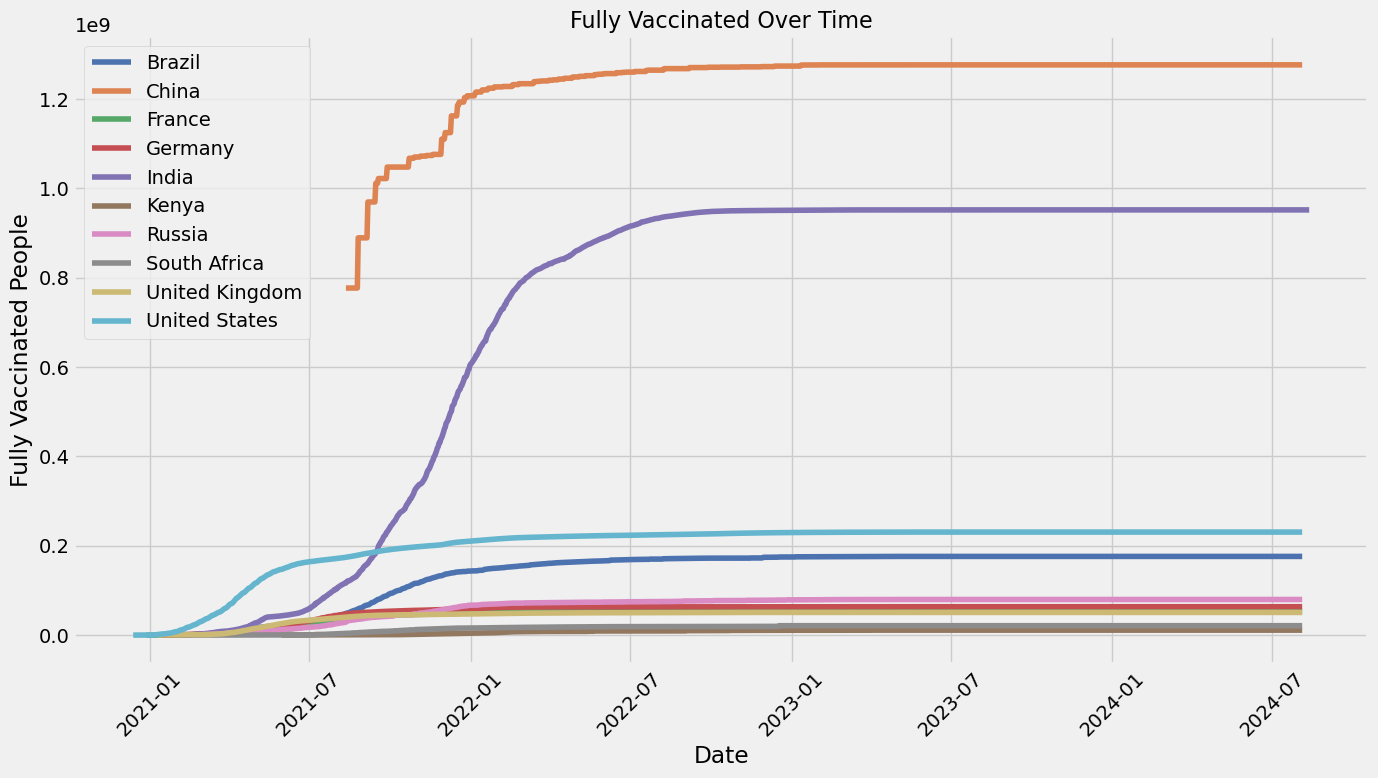

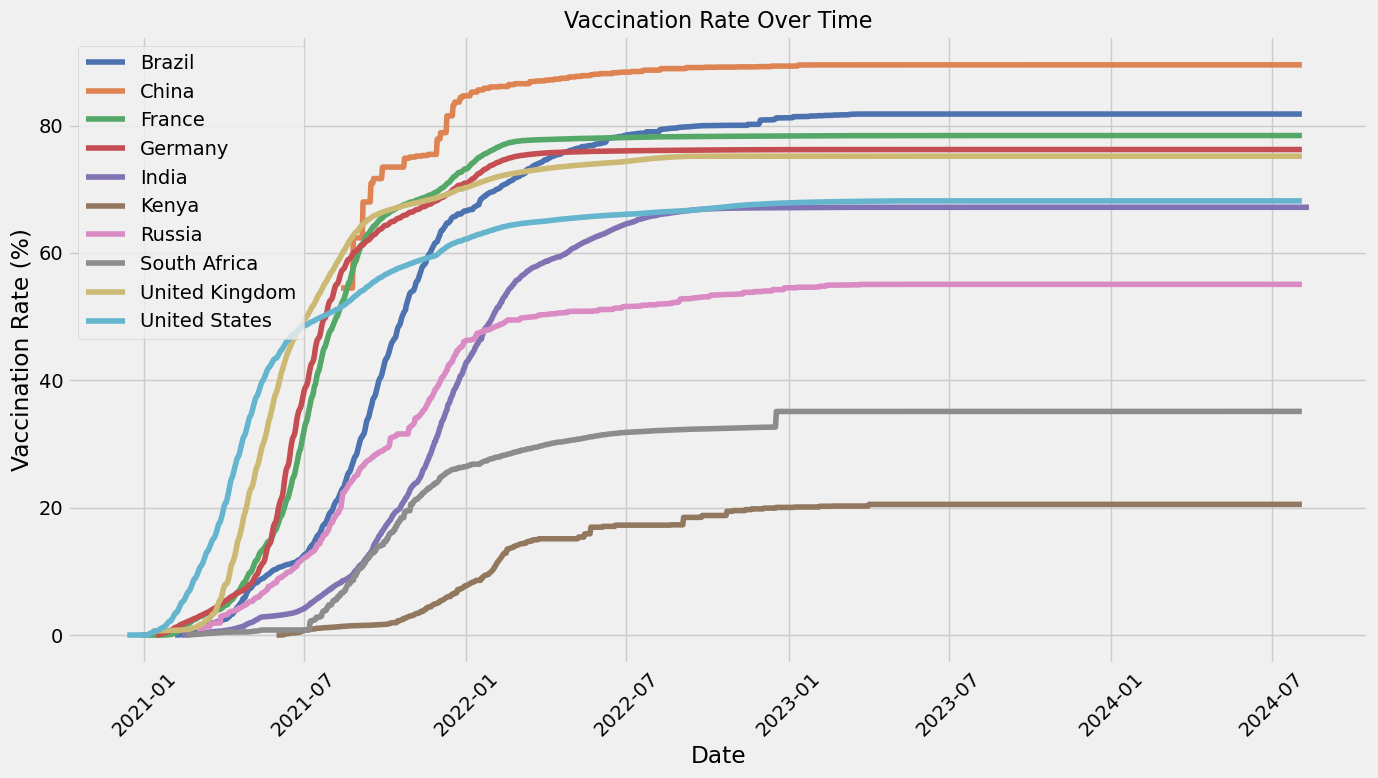

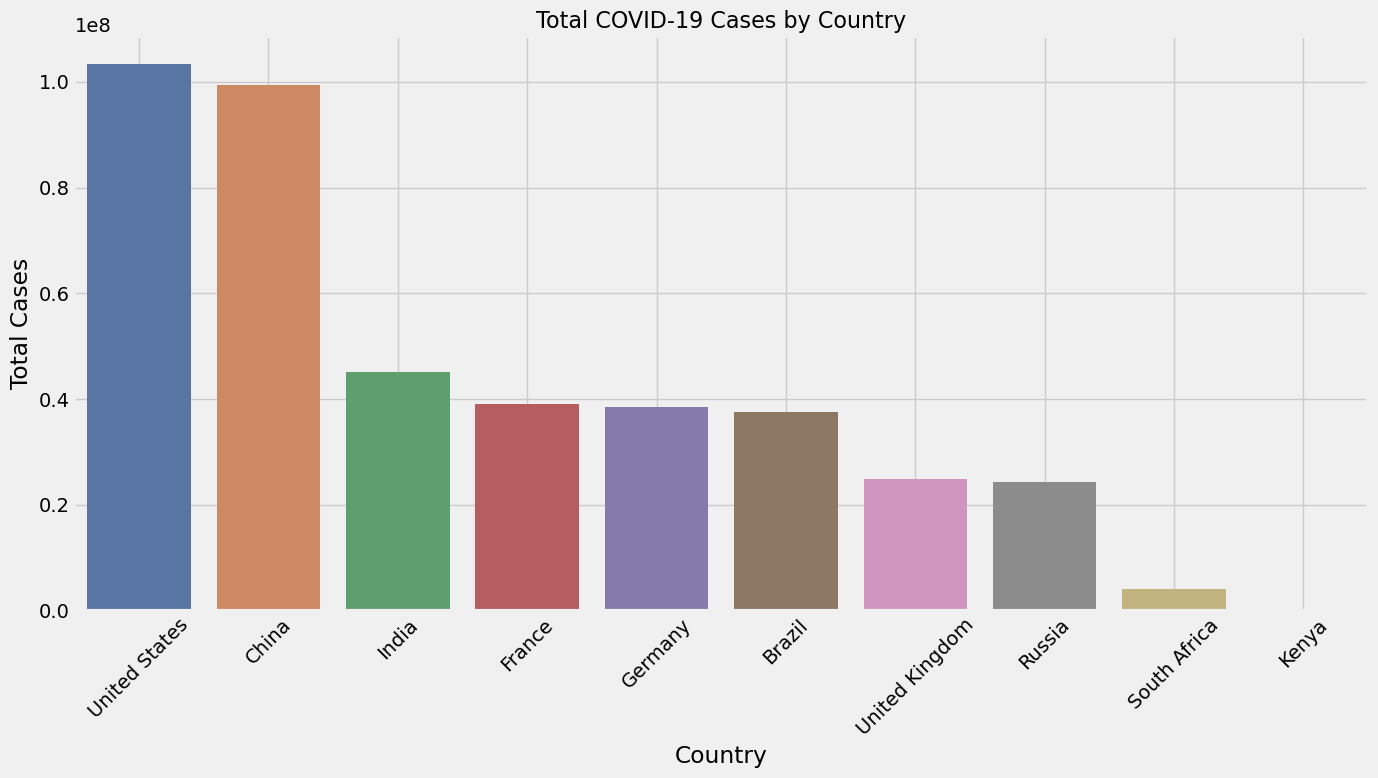

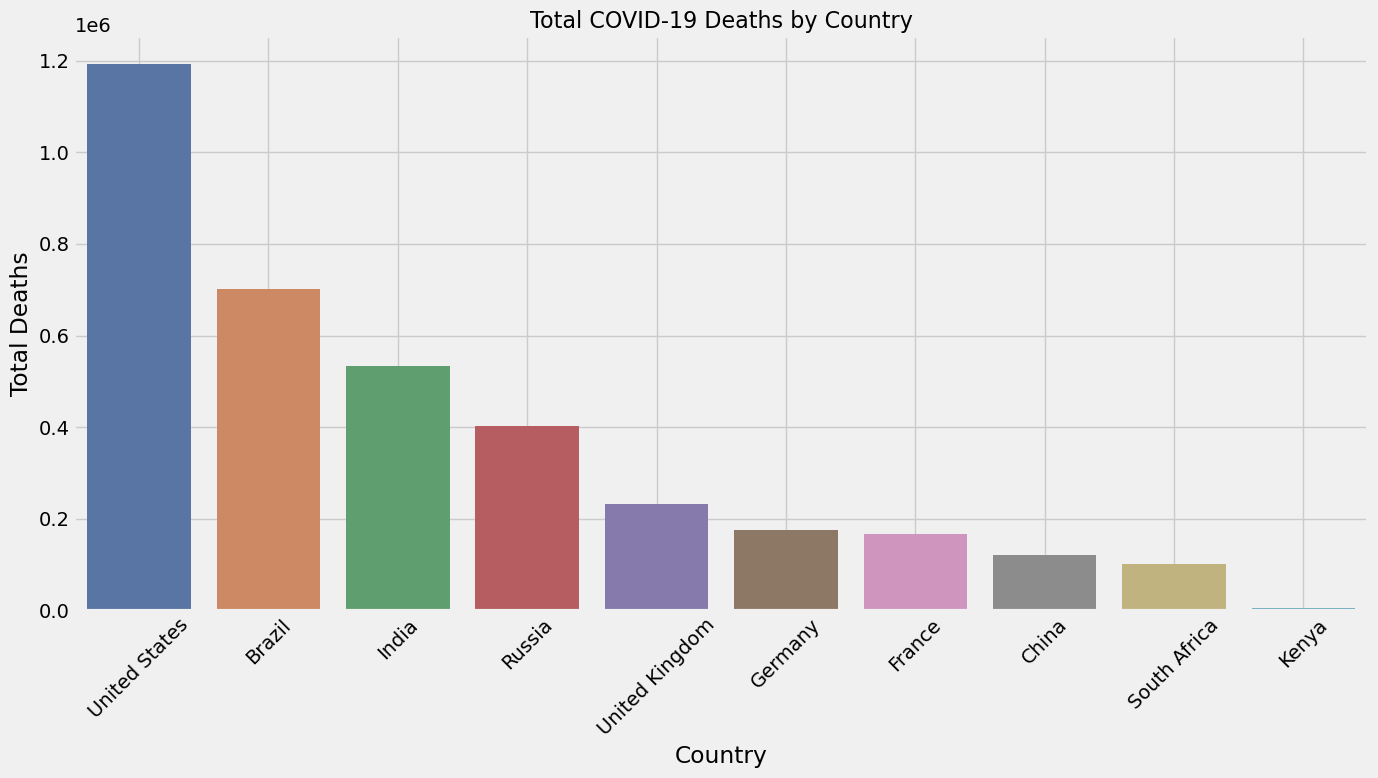

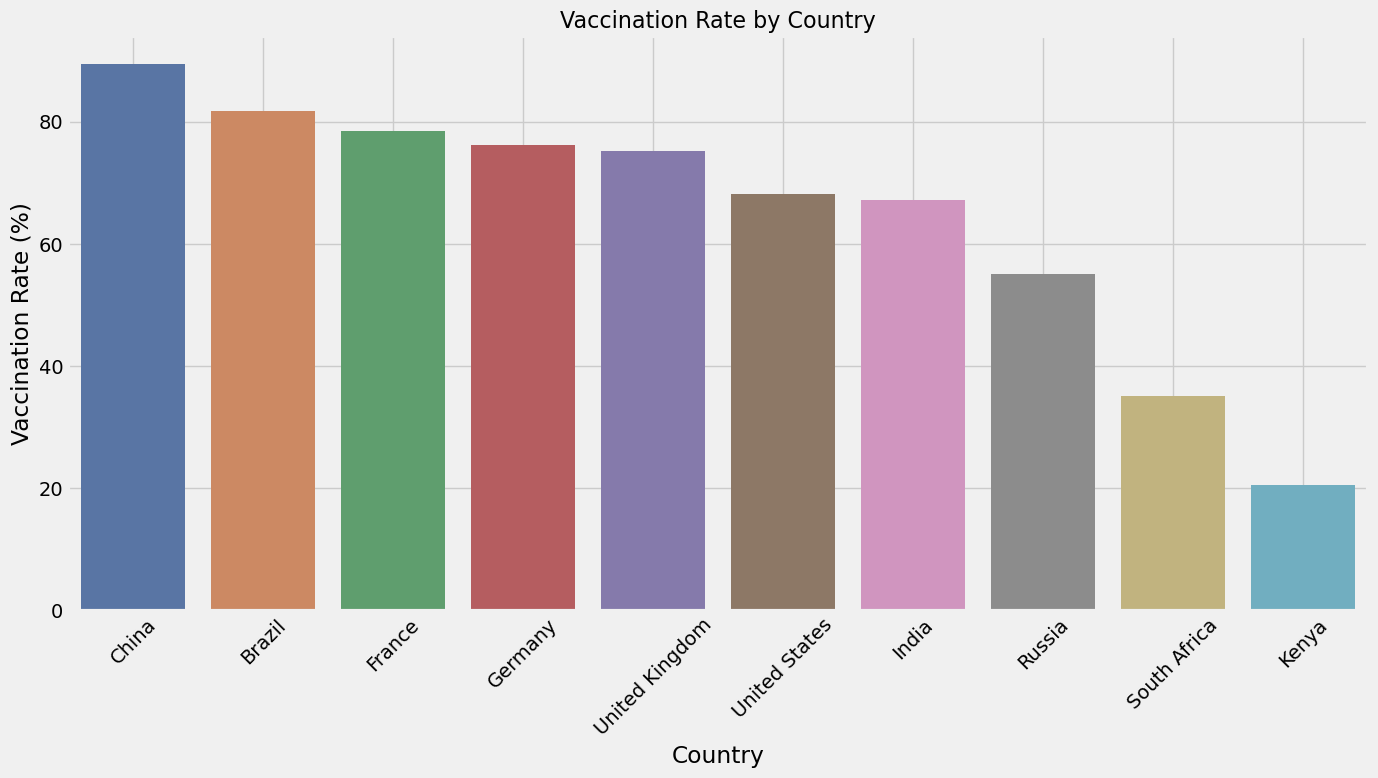


4. CHOROPLETH MAPS
--------------------------------------------------------------------------------


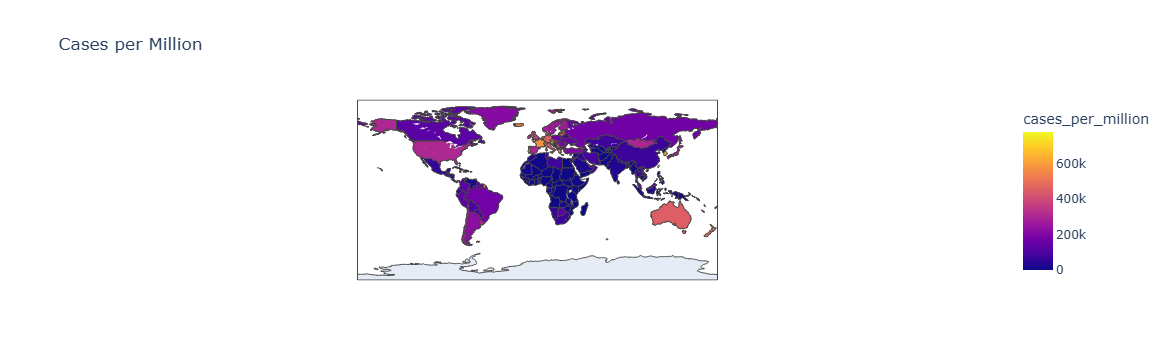

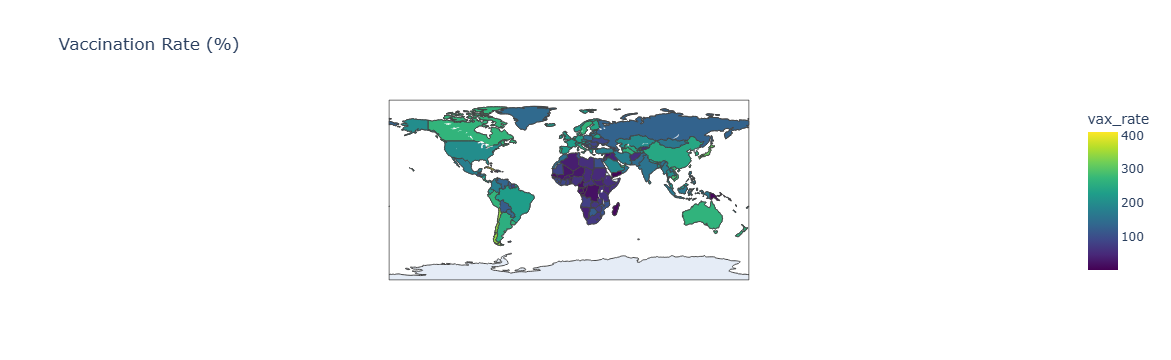


5. INSIGHTS & CORRELATION
--------------------------------------------------------------------------------
Latest date in dataset: 2024-08-12
Total Global Cases: 775,866,783
Total Global Deaths: 7,057,132
Global Death Rate: 0.91%


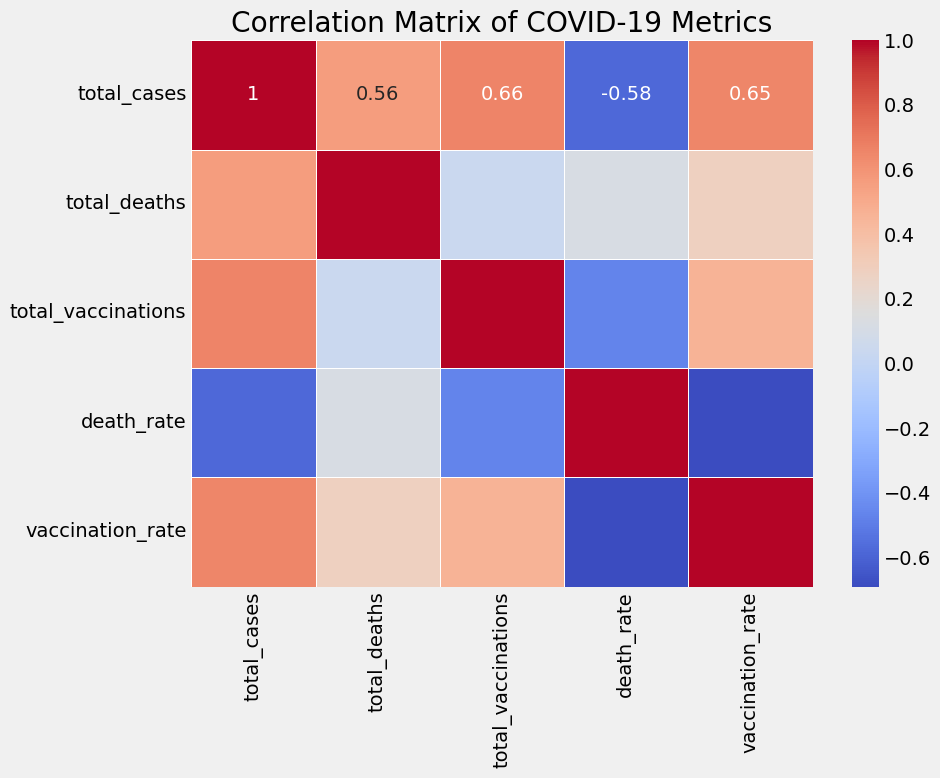

In [3]:
# COVID-19 Global Data Tracker
# Analysis of COVID-19 cases, deaths, and vaccinations globally

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('fivethirtyeight')
sns.set_palette("deep")
plt.rcParams.update({'figure.figsize': [12, 8], 'figure.dpi': 100})

# ----------------------- 1. DATA COLLECTION -----------------------
print("1. DATA COLLECTION\n" + "-" * 80)

DATA_URL = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
try:
    df = pd.read_csv(DATA_URL)
    print("Data successfully loaded from source.")
except Exception as e:
    print(f"Failed to load data: {e}")
    exit()

# ------------------ 2. DATA EXPLORATION & CLEANING ------------------
print("\n2. DATA EXPLORATION & CLEANING\n" + "-" * 80)

df['date'] = pd.to_datetime(df['date'])
print("Date column converted to datetime.")

# Filter countries of interest
countries = ['United States', 'India', 'Brazil', 'United Kingdom', 'South Africa', 
             'Kenya', 'France', 'Germany', 'Russia', 'China']
df_filtered = df[df['location'].isin(countries)]

# Handle missing values in key metrics
metrics = ['total_cases', 'new_cases', 'total_deaths', 'new_deaths', 
           'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated']

df_filtered.sort_values(by=['location', 'date'], inplace=True)
df_filtered[metrics] = df_filtered.groupby('location')[metrics].ffill()

# -------------------- 3. FEATURE ENGINEERING --------------------
df_filtered['new_cases_7day_avg'] = df_filtered.groupby('location')['new_cases'].transform(lambda x: x.rolling(7).mean())
df_filtered['death_rate'] = (df_filtered['total_deaths'] / df_filtered['total_cases']) * 100
df_filtered['vaccination_rate'] = (df_filtered['people_fully_vaccinated'] / df_filtered['population']) * 100

# ------------------ 4. PLOTTING FUNCTIONS ------------------

def plot_metric(df, column, title, ylabel):
    plt.figure(figsize=(14, 8))
    for country in df['location'].unique():
        country_data = df[df['location'] == country]
        if country_data[column].notna().any():
            plt.plot(country_data['date'], country_data[column], label=country)
    plt.title(title, fontsize=16)
    plt.xlabel("Date"); plt.ylabel(ylabel)
    plt.legend(); plt.grid(True); plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ------------------ 5. TIME SERIES VISUALIZATION ------------------
print("\n3. TIME SERIES VISUALIZATION\n" + "-" * 80)
plot_metric(df_filtered, 'total_cases', 'Total COVID-19 Cases Over Time', 'Total Cases')
plot_metric(df_filtered, 'total_deaths', 'Total COVID-19 Deaths Over Time', 'Total Deaths')
plot_metric(df_filtered, 'new_cases_7day_avg', 'New COVID-19 Cases (7-day Avg)', 'New Cases (7d Avg)')
plot_metric(df_filtered, 'death_rate', 'Death Rate Over Time', 'Death Rate (%)')
plot_metric(df_filtered, 'total_vaccinations', 'Total Vaccinations Over Time', 'Total Vaccinations')
plot_metric(df_filtered, 'people_fully_vaccinated', 'Fully Vaccinated Over Time', 'Fully Vaccinated People')
plot_metric(df_filtered, 'vaccination_rate', 'Vaccination Rate Over Time', 'Vaccination Rate (%)')

# ------------------ 6. LATEST COUNTRY STATS ------------------
latest = df_filtered.groupby('location').last().reset_index()

def bar_plot(data, x, y, title, ylabel):
    plt.figure(figsize=(14, 8))
    sns.barplot(data=data.sort_values(y, ascending=False), x=x, y=y)
    plt.title(title, fontsize=16)
    plt.xlabel("Country"); plt.ylabel(ylabel)
    plt.xticks(rotation=45); plt.grid(True)
    plt.tight_layout()
    plt.show()

bar_plot(latest, 'location', 'total_cases', 'Total COVID-19 Cases by Country', 'Total Cases')
bar_plot(latest, 'location', 'total_deaths', 'Total COVID-19 Deaths by Country', 'Total Deaths')
bar_plot(latest, 'location', 'vaccination_rate', 'Vaccination Rate by Country', 'Vaccination Rate (%)')

# ------------------ 7. CHOROPLETH MAPS ------------------
print("\n4. CHOROPLETH MAPS\n" + "-" * 80)

global_latest = df.groupby('location').last().reset_index()
global_latest['cases_per_million'] = (global_latest['total_cases'] / global_latest['population']) * 1e6
global_latest['deaths_per_million'] = (global_latest['total_deaths'] / global_latest['population']) * 1e6
global_latest['vax_rate'] = (global_latest['total_vaccinations'] / global_latest['population']) * 100

try:
    px.choropleth(global_latest, locations="iso_code", color="cases_per_million",
                  hover_name="location", title="Cases per Million",
                  color_continuous_scale=px.colors.sequential.Plasma).show()

    px.choropleth(global_latest, locations="iso_code", color="vax_rate",
                  hover_name="location", title="Vaccination Rate (%)",
                  color_continuous_scale=px.colors.sequential.Viridis).show()
except Exception as e:
    print(f"Map error: {e}")

# ------------------ 8. INSIGHTS ------------------
print("\n5. INSIGHTS & CORRELATION\n" + "-" * 80)

print(f"Latest date in dataset: {df_filtered['date'].max().strftime('%Y-%m-%d')}")
print(f"Total Global Cases: {df['total_cases'].max():,.0f}")
print(f"Total Global Deaths: {df['total_deaths'].max():,.0f}")
print(f"Global Death Rate: {(df['total_deaths'].max() / df['total_cases'].max()) * 100:.2f}%")

# Correlation matrix
corr_cols = ['total_cases', 'total_deaths', 'total_vaccinations', 'death_rate', 'vaccination_rate']
corr_matrix = latest[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of COVID-19 Metrics")
plt.tight_layout()
plt.show()
